In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '18/06/2020'
id_noticia = '238252'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'

In [3]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[0]

In [4]:
# Prepare
dfL['Fecha'] = fecha
# A partir del 14/05/2020 se cambia el formato del dato añadiendo en la misma columna el número de nuevos casos
for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']:
    dfL[col] = dfL[col].str.split(' ').str[0]

dfL

,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Curados,Fecha
0,Almería,532,246,41,54,726,18/06/2020
1,Cádiz,1.288,592,84,164,1.342,18/06/2020
2,Córdoba,1.351,562,77,117,1.607,18/06/2020
3,Granada,2.467,1.209,135,287,2.930,18/06/2020
4,Huelva,407,222,30,48,478,18/06/2020
5,Jaén,1.474,769,91,186,1.701,18/06/2020
6,Málaga,2.854,1.496,168,288,3.339,18/06/2020
7,Sevilla,2.498,1.213,152,289,2.855,18/06/2020
8,Total,12.871,6.309,778,1.433,14.978,18/06/2020


In [5]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
data.sample(5)

,Provincia,Fecha,variable,value
35,Total,18/06/2020,Fallecimientos,1.433
14,Jaén,18/06/2020,Hospitalización,769
43,Sevilla,18/06/2020,Curados,2.855
39,Granada,18/06/2020,Curados,2.930
22,Huelva,18/06/2020,UCI,30


In [6]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [7]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
dfL.tail()

,Provincia,Fecha,variable,value
2965,Huelva,2020-06-18,Curados,478
2966,Jaén,2020-06-18,Curados,1701
2967,Málaga,2020-06-18,Curados,3339
2968,Sevilla,2020-06-18,Curados,2855
2969,Total,2020-06-18,Curados,14978


In [8]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [9]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [10]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').pct_change() * 100
dfV.tail()

Curados  Fallecimientos  Hospitalización  PCR Positivo  \
Provincia Fecha                                                                 
Total     2020-06-14  0.034233        0.069881         0.015868      0.031162   
          2020-06-15 -0.006844        0.000000         0.000000      0.015576   
          2020-06-16  0.766598       -0.069832         0.031731      0.031148   
          2020-06-17  0.869447        0.069881         0.047581      0.077845   
          2020-06-18  0.861953        0.069832         0.015853      0.116677   

                         UCI  
Provincia Fecha               
Total     2020-06-14  0.0000  
          2020-06-15  0.0000  
          2020-06-16  0.1287  
          2020-06-17  0.0000  
          2020-06-18  0.0000

In [11]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]

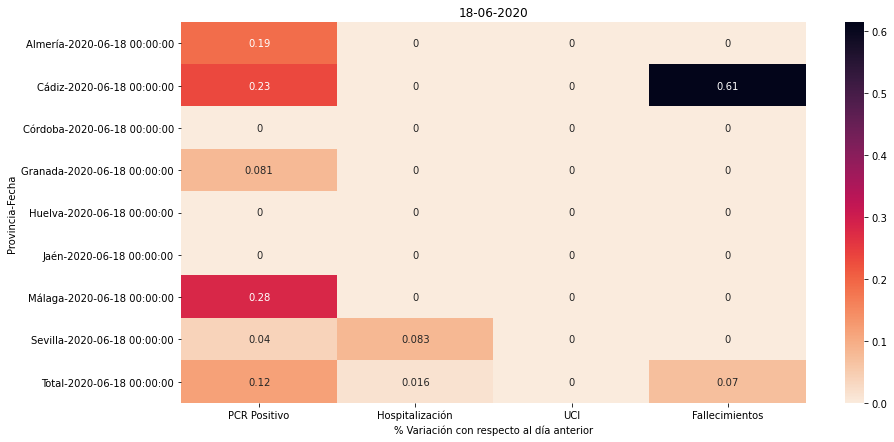

In [12]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG[['PCR Positivo', 'Hospitalización', 'UCI', 'Fallecimientos']], annot=True, cmap=cmap)

# Add label for horizontal axis
plt.xlabel('% Variación con respecto al día anterior')
plt.show()

In [13]:
provincia = 'Total'
dias = 15
# data = df.loc[provincia][['Hospitalización', 'Curados', 'Fallecimientos']].diff().tail(dias).copy()
data = df.loc[provincia].diff().tail(dias).copy()
titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia


In [14]:
print(titulo)
print(data)

Nuevos casos en los últimos 15 días en Total
variable    Curados  Fallecimientos  Hospitalización  PCR Positivo  UCI
Fecha                                                                  
2020-06-04    106.0             3.0             10.0          16.0  0.0
2020-06-05    114.0             1.0             -1.0          12.0  1.0
2020-06-06    123.0             0.0              4.0          23.0  3.0
2020-06-07     15.0             2.0              2.0           8.0  0.0
2020-06-08     27.0             0.0              0.0          -1.0  0.0
2020-06-09    181.0             3.0              0.0           4.0  0.0
2020-06-10    110.0             0.0              2.0          11.0  1.0
2020-06-11     83.0             1.0              5.0          10.0  1.0
2020-06-12     68.0             0.0              2.0           9.0  0.0
2020-06-13    133.0             2.0              2.0           7.0  2.0
2020-06-14      5.0             1.0              1.0           4.0  0.0
2020-06-15     -1.0

Nuevos casos en los últimos 15 días en Total. (Nuevos ingresos hospitalarios)


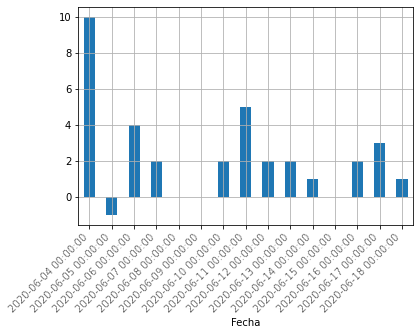

In [15]:
print(titulo + '. (Nuevos ingresos hospitalarios)')
data['Hospitalización'].plot(kind='bar', grid=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

In [16]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values('dias', ascending=False)

variable,Fecha,Hospitalización,dias
Provincia,,,
Jaén,2020-06-03,1.0,15 days
Huelva,2020-06-06,1.0,12 days
Málaga,2020-06-12,2.0,6 days
Almería,2020-06-13,1.0,5 days
Córdoba,2020-06-14,1.0,4 days
Granada,2020-06-16,3.0,2 days
Cádiz,2020-06-17,3.0,1 days
Total,2020-06-18,1.0,0 days
Sevilla,2020-06-18,1.0,0 days
